In [583]:
# Here we test on the DRIVE dataset

In [584]:
%load_ext autoreload
%autoreload 2
from sys import path
path.append('/home/clement/Documents/Code/JuNNo/lib')
path.append('../code/')
import junno.datasets as J
import cv2
import numpy as np
import torch
import pandas as pd 
import functools as fct
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.stats as st
from utils.eval.tester import Tester
from utils.eval.metrics import Metrics
from manager import Trainer
import yaml
from easydict import EasyDict
import pprint
from sklearn.utils import class_weight
import sklearn.metrics as met
from networks.unet import UNet
import datetime
pp = pprint.PrettyPrinter(indent=4)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [585]:
# RAW

size = 512
# PATH = '/home/clement/Documents/database/arnaud/DRIVE/test/0-images'
# d_raw = J.images(PATH+'/png_format', reshape=size, keep_proportion='pad')
PATH = '/home/clement/Documents/database/arnaud/messidor/database/'
d_raw = J.images(PATH+'images/', reshape=size, keep_proportion='pad')

d_raw

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [217]:
# GREEN CHANNEL

def extract_green(data):
    return (data[1,:,:])[np.newaxis, :, :]

d_green = d_raw.apply('data', extract_green)
d_green

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [218]:
# BLUE CHANNEL

def extract_blue(data):
    return (data[0,:,:])[np.newaxis, :, :]

d_blue = d_raw.apply('data', extract_blue)
d_blue

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [219]:
# RED CHANNEL

def extract_red(data):
    return (data[2,:,:])[np.newaxis, :, :]

d_red = d_raw.apply('data', extract_red)
d_red

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [220]:
# CLAHE

def median_filter_clahe(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return bg
def subtract_median_bg_image(im):
    return cv2.addWeighted(im, 4, median_filter_clahe(im), -4, 128)

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted(im, 4, bg, -4, 128)


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
def ROI(img, threshold=5):
    """
    Assume img to be a uint8, h,w c format image
    :param img: Array
    :return: A mask containing the region of interest of the image, ie True where the circular Fundus is and False
    elsewhere
    """
    mask = cv2.medianBlur(img[:, :, 2], 21) > threshold

    return mask


normalize = False 
# If true, the function will standardize the LAB components according to a given mean and std, channel wise.
L_MEAN = 31.319101
A_MEAN = 17.877468
B_MEAN = 29.181826
L_STD = 12.684237
A_STD = 7.002096
B_STD = 10.272004

def LAB_clahe(img):
    mask = ROI(img)
    mean_b = np.median(img[:, :, 0][mask])
    mean_g = np.median(img[:, :, 1][mask])
    mean_r = np.median(img[:, :, 2][mask])
    mean_channels = [mean_b, mean_g, mean_r]
    img = np.clip(
        img.astype(np.float32) - median_filter_clahe(img) * np.expand_dims(mask, 2) + np.asarray(mean_channels).astype(
            np.uint8), 0, 255)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    lab = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    
    if normalize:
        lab = (lab * np.expand_dims(mask, 2)).astype(np.float32)
        lab[:, :, 0] -= lab[:, :, 0].mean()
        lab[:, :, 0] *= L_STD / (lab[:, :, 0].std() + 1e-7)
        lab[:, :, 0] += L_MEAN

        lab[:, :, 1] -= lab[:, :, 1].mean()
        lab[:, :, 1] *= A_STD / (lab[:, :, 1].std() + 1e-7)
        lab[:, :, 1] += A_MEAN

        lab[:, :, 2] -= lab[:, :, 2].mean()
        lab[:, :, 2] *= B_STD / (lab[:, :, 2].std() + 1e-7)
        lab[:, :, 2] += B_MEAN
        
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return rgb * np.expand_dims(mask, 2)


def preprocess(data):
    return LAB_clahe(data)


d_clahe = d_raw.apply_cv('data', preprocess)
d_clahe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [221]:
# MORPHOPREPROCESS

def preprocess(x):
  return cv2.GaussianBlur(subtract_median_bg_image(x), (7,7), 0)
def morphopreprocess(x):
  k = np.max(x.shape)//20*2+1
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k//2+1,k//2+1))
  mask_org = (x[:,:,2]>20).astype(np.uint8)
  mask = cv2.erode(mask_org, np.ones((15,15), np.uint8))
  mask = np.expand_dims(mask, 2).astype(np.uint8)
  mask_org = np.expand_dims(mask_org, 2)
  dilation = cv2.dilate(x,kernel,iterations = 1)
  bgr = preprocess(dilation*(1-mask)+mask*x)*mask
  return bgr
d_morph = d_raw.apply_cv('data', morphopreprocess)
d_morph 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [222]:
# MORPHGREEN

d_morph_g = d_morph.apply('data', extract_green)
d_morph_g

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [223]:
# MEDIAN FILTER

def median_filter(im):
    k = 3
    bg = cv2.medianBlur(im, k)
    return bg

d_median = d_raw.apply_cv('data', median_filter)
d_median = d_raw.apply_cv('data', subtract_median_bg_image)
d_median

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [224]:
# GT - VESSELS - TESTING - 

def binarize(gt):
    return (gt>0).astype(np.int)

def binarizeSP(gt):
    return (gt>0.02).astype(np.int)

# PATH = '/home/clement/Documents/database/arnaud/DRIVE/test'

# d_gt_1 = J.images(PATH + '/2-label_Vessel_1st/png_format', reshape = size).apply('data', binarize)

# d_gt_2 = J.images(PATH + '/2-label_Vessel_2nd/png_format', reshape = size).apply('data', binarizeSP)
# d_gt_2 = d_gt_2.apply('data', extract_green)
# d_gt_2

d_gt = J.images(PATH + 'Vessels/MESSIDOR', reshape = size).apply('data', binarize)
d_gt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [298]:
# SETS
test_sets = [d_raw, d_red, d_green, d_blue, d_clahe, d_median, d_morph, d_morph_g]
variant_name = ['ves-raw', 'ves-r', 'ves-g', 'ves-b', 'ves-clahe', 'ves-median', 'ves-morph', 'ves-morph-g']
# test_sets = [d_raw]
# variant_name = ['ves-raw']

In [299]:
code = '2019-12-07T18:50:55.141984'
folder = '2019-12-07'

In [259]:
baseConfigPath = '../code/config.yaml'
with open(baseConfigPath, 'r') as f:
    yaml_file = yaml.load(f, Loader=yaml.FullLoader)
    config = EasyDict(yaml_file)
     
config.variant.type = variant_name[0]
config.variant.code = code
    
if ((config.variant.type).endswith('-g') or (config.variant.type).endswith('-b') or (config.variant.type).endswith('-r')):
    config.model.input_chan = 1
    
if ((config.variant.type).endswith('-gb')):
    config.model.input_chan = 2
    
if config.variant.type == 'concat-g':
    config.model.input_chan = 4
        
if config.variant.type == 'concat-mor':
    config.model.input_chan = 6
        
PATH = '/home/clement/Documents/Arnaud/models/%s' % folder
model = UNet(config = config.model)
model.load_state_dict(torch.load(PATH + ('/uNet_%s_%s.pth' % (code, variant_name[0])))) 
model.eval()
model = model.to('cuda')
tester = Tester()
    
if (variant_name[0]).startswith('ves'):
    d_pred = test_sets[0].apply_torch('data', model, device='cuda')
    joined_pred1 = J.join([d_pred.col.name, d_gt_1.col.name], x=d_pred.col.data, gt=d_gt_1.col.data).apply('gt', binarize)
    joined_pred2 = J.join([d_pred.col.name, d_gt_2.col.name], x=d_pred.col.data, gt=d_gt_2.col.data).apply('gt', binarize)

ValueError: 1 is not a valid index: dataset size is 0

In [300]:
# Testing loop

results_per_image = np.zeros((len(test_sets), 3, d_gt.size))

def softmax(x):
    return np.exp(x[1])/np.sum(np.exp(x), axis=0)

for i in range(len(test_sets)):
    # Loading model
    
    baseConfigPath = '../code/config.yaml'
    with open(baseConfigPath, 'r') as f:
        yaml_file = yaml.load(f, Loader=yaml.FullLoader)
        config = EasyDict(yaml_file)
        
    config.variant.type = variant_name[i]
    config.variant.code = code
    
    if ((config.variant.type).endswith('-g') or (config.variant.type).endswith('-b') or (config.variant.type).endswith('-r')):
        config.model.input_chan = 1
    
    if ((config.variant.type).endswith('-gb')):
        config.model.input_chan = 2
    
    if config.variant.type == 'concat-g':
        config.model.input_chan = 4
        
    if config.variant.type == 'concat-mor':
        config.model.input_chan = 6
        
    PATH = '/home/clement/Documents/Arnaud/models/%s' % folder
    model = UNet(config = config.model)
    model.load_state_dict(torch.load(PATH + ('/uNet_%s_%s.pth' % (code, variant_name[i])))) 
    model.eval()
    model = model.to('cuda')
    tester = Tester()
    
    if (variant_name[i]).startswith('ves'):
        d_pred = test_sets[i].apply_torch('data', model, device='cuda')
#         joined_pred1 = J.join([d_pred.col.name, d_gt_1.col.name], x=d_pred.col.data, gt=d_gt_1.col.data).apply('gt', binarize)
#         joined_pred2 = J.join([d_pred.col.name, d_gt_2.col.name], x=d_pred.col.data, gt=d_gt_2.col.data).apply('gt', binarize)
        joined_pred = J.join([d_pred.col.name, d_gt.col.name], x=d_pred.col.data, gt=d_gt.col.data).apply('gt', binarize)
        
    # TESTS POUR LESIONS PAS ENCORE DEFINIS, CODE INCORRECT
    else:
        d_pred = test_sets[i].apply_torch('x', model, device='cuda')
        joined_pred = J.join([d_pred.col.name, test_d_gt.col.name], x=d_pred.col.x, gt=test_d_gt.col.data).apply('gt', binarize)
    
#     tester.evaluate(joined_pred1, 'x', 'gt', pred_index=1)
#     tester.metrics(path="/home/clement/Documents/Arnaud/models/%s" % folder, name="/%s_metrics_DRIVE_1_%s" % (code, variant_name[i]))
#     tester.evaluate(joined_pred2, 'x', 'gt', pred_index=1)
#     tester.metrics(path="/home/clement/Documents/Arnaud/models/%s" % folder, name="/%s_metrics_DRIVE_2_%s" % (code, variant_name[i]))

    pred = joined_pred.apply('x', softmax)
    m = Metrics()
    def pre_rec(gt, x):
        return m.auc_precision_recall_curve(gt.flatten(), x.flatten())
    def recall(gt, x):
        return met.recall_score(gt.flatten(), x.flatten()>0.5)
    def kappa(gt, x):
        return met.cohen_kappa_score(gt.flatten(), x.flatten()>0.5)

    pred_pr_auc = pred.apply('auc', pre_rec).apply('rec', recall).apply('kappa', kappa).cache()
    results_per_image[i, :, :] = np.array(pred_pr_auc[:, ['auc', 'rec', 'kappa']])
        
    
    

In [409]:
pred_pr_auc


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatabaseView(children=(HBox(children=(ToolBar(children=(ToolButton(html='<i class="fa fa-eye-slash" style="fon…

In [351]:
results_per_image[0]-results_per_image[2]

array([[ 2.50294131e-02,  3.44479568e-02,  3.03302041e-02,
         8.74693391e-03,  3.65465229e-02,  3.77387894e-02,
         3.53090304e-02,  3.34406386e-02,  3.19604579e-02,
         2.03771133e-02,  3.85741067e-02,  2.71633940e-02,
         4.73394581e-02,  2.92877528e-02,  3.67674529e-02,
         3.17068364e-02,  7.26402101e-03,  3.74368219e-02,
         3.40528746e-02,  4.00918879e-02,  2.85930488e-02,
         1.94122487e-02,  4.04846022e-02,  3.53232353e-02,
        -7.52781411e-03,  1.86418589e-02,  3.71119098e-02,
         7.93753596e-03, -3.66834047e-03,  3.33793330e-02,
         2.94672236e-02,  2.88816485e-02,  2.05342843e-02,
         2.21391231e-03,  1.77250113e-02,  1.05193249e-02,
         3.24038347e-02,  2.63679605e-02,  2.56885266e-02,
         2.35357669e-02,  3.02122125e-02,  2.96163016e-02,
         2.97487974e-02,  3.62307934e-02,  3.92797974e-02,
         3.09853989e-02,  3.50901636e-02,  2.63123846e-02,
         4.35867974e-02,  3.67826317e-02,  3.86757124e-0

In [477]:
xx = (results_per_image[7, 2, :]-results_per_image[0, 2, :])
xx[23] = 0
# np.argmin(xx)
np.argmax(xx)
xx[80]=0


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 0., 4., 1., 0., 3., 0., 0., 1., 2., 3., 2., 1., 1.,
        3., 2., 1., 4., 6., 2., 3., 8., 4., 1., 5., 1., 2., 1., 2., 4., 1.,
        3., 6., 1., 2., 2., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.57467625, 0.57775744, 0.58083864, 0.58391983, 0.58700102,
        0.59008221, 0.5931634 , 0.5962446 , 0.59932579, 0.60240698,
        0.60548817, 0.60856937, 0.61165056, 0.61473175, 0.61781294,
        0.62089413, 0.62397533, 0.62705652, 0.63013771, 0.6332189 ,
        0.6363001 , 0.63938129, 0.64246248, 0.64554367, 0.64862486,
        0.65170606, 0.65478725, 0.65786844, 0.66094963, 0.66403083,
        0.66711202, 0.67019321, 0.6732744 , 0.67635559, 0.67943679,
        0.68251798, 0.68559917, 0.68868036, 0.69176156, 0.69484275,
        0.69792394

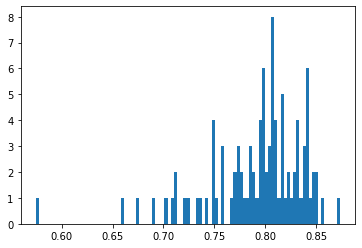

In [488]:
#plt.hist(xx, bins=97)
plt.hist(results_per_image[0, 2, :], bins=97)

In [435]:
st.ttest_rel(results_per_image[5, 2, :], results_per_image[5, 2, :])

Ttest_relResult(statistic=nan, pvalue=nan)

In [486]:
st.shapiro(clean_res_per_img)
#st.shapiro(results_per_image[5, 2, :]-results_per_image[2, 2, :])

(0.7650725245475769, 0.0)

In [551]:
st.mannwhitneyu(results_per_image[5, 0, :], results_per_image[7, 0, :])[1]

1.4054157639452612e-16

In [541]:
pvalues = -np.ones([3, len(test_sets), len(test_sets)])


for i in range(3):
    for j in range(len(test_sets)):
        for k in (np.array(range(len(test_sets)-j))+j):
            pvalues[i,j,k] = st.mannwhitneyu(results_per_image[j, i, :], results_per_image[k, i, :])[1]

In [538]:
np.array(range(len(test_sets)-j))+1

array([1, 2, 3, 4, 5, 6, 7, 8])

In [586]:
mean_metrics = np.apply_along_axis(np.mean, 2, results_per_image)
mean_metrics

array([[0.73936853, 0.77218626, 0.79188316],
       [0.4350398 , 0.48066449, 0.46515773],
       [0.71122552, 0.81888028, 0.80165065],
       [0.08842667, 0.55657351, 0.09234747],
       [0.70431233, 0.80317667, 0.78547033],
       [0.74972163, 0.82689775, 0.80951516],
       [0.71902312, 0.76120497, 0.77331579],
       [0.70510233, 0.76628287, 0.77166671]])

In [587]:
mean_metrics[:,0]

array([0.73936853, 0.4350398 , 0.71122552, 0.08842667, 0.70431233,
       0.74972163, 0.71902312, 0.70510233])

In [601]:
tab = {'Preprocessing': ['raw', 'red', 'green', 'blue', 'clahe', 'median', 'morph', 'morph+green'],
        'P-R AUC': mean_metrics[:,0],
        'Recall': mean_metrics[:,1],
        'Kappa': mean_metrics[:,2]}
df = pd.DataFrame(tab)


print(df)

  Preprocessing   P-R AUC    Recall     Kappa
0           raw  0.739369  0.772186  0.791883
1           red  0.435040  0.480664  0.465158
2         green  0.711226  0.818880  0.801651
3          blue  0.088427  0.556574  0.092347
4         clahe  0.704312  0.803177  0.785470
5        median  0.749722  0.826898  0.809515
6         morph  0.719023  0.761205  0.773316
7   morph+green  0.705102  0.766283  0.771667


In [558]:

pd.DataFrame(pvalues[2]).to_csv("/home/clement/Documents/Arnaud/models/pvalues_kappa.csv")

In [578]:
def matshow(matrix, sig = 0.01, mid_sig=0.04, indexes = None, fig_size=(8,10), title='Default title', scores=None):
    fig= plt.figure(figsize=fig_size)
    ax = fig.subplots()
    def hextofloats(h):
        return [int(h[i:i + 2], 16) / 255. for i in (1, 3, 5)] # skip '#'
    red = hextofloats(mcolors.TABLEAU_COLORS['tab:red'])
    green = hextofloats(mcolors.TABLEAU_COLORS['tab:green'])
    orange = hextofloats(mcolors.TABLEAU_COLORS['tab:orange'])
    black  = np.asarray(((0,0,0)))
    white = np.asarray((0.75,0.75,0.75))
    color_maps = np.zeros(matrix.shape+(3,))
    color_maps[matrix==matrix] = red
    color_maps[matrix<mid_sig] = orange
    color_maps[matrix<sig] = green
    color_maps[np.tril(matrix)!=0] = white
    for (i, j), z in np.ndenumerate(matrix):
        if i < j:
            ax.text(j, i, '{:0.1e}'.format(z), ha='center', va='center')
        if scores is not None:
            if i==j:
                color_maps[i,j] = black
                ax.text(j, i, '{:.0%}'.format(scores[i]), ha='center', va='center', color='white')
    ax.imshow(color_maps)
    if indexes is not None:
        ax.set_xticklabels(['']+indexes, rotation=45)
        ax.set_yticklabels(['']+indexes)
    ax.set_title(title)
    return fig, ax

(<Figure size 576x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0250b98250>)

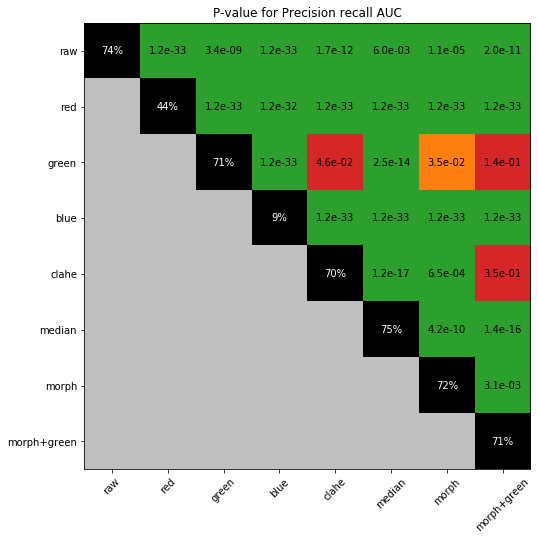

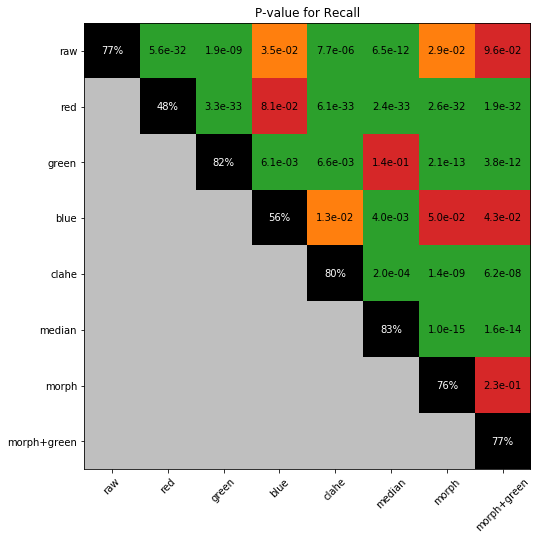

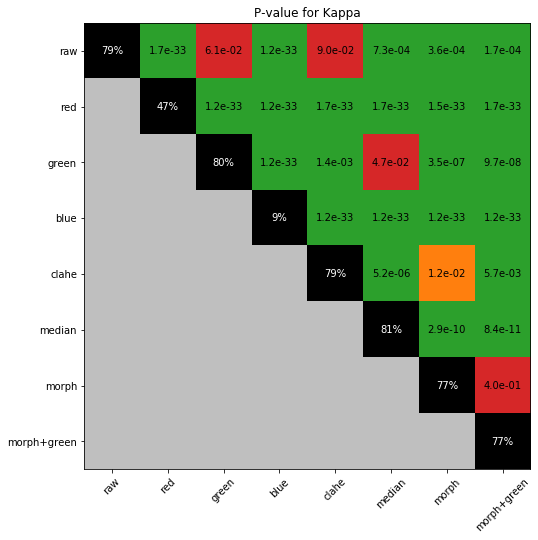

In [581]:
matshow(pvalues[0], indexes=['raw', 'red', 'green', 'blue', 'clahe', 'median', 'morph', 'morph+green'], title='P-value for Precision recall AUC', scores=mean_metrics[:,0])
matshow(pvalues[1], indexes=['raw', 'red', 'green', 'blue', 'clahe', 'median', 'morph', 'morph+green'], title='P-value for Recall', scores=mean_metrics[:,1])
matshow(pvalues[2], indexes=['raw', 'red', 'green', 'blue', 'clahe', 'median', 'morph', 'morph+green'], title='P-value for Kappa', scores=mean_metrics[:,2])